In [1]:
import cv2

In [37]:
import numpy as np 
import os 
from random import shuffle
from tqdm import tqdm

Train_dir = r'C:\Users\User\OneDrive - Asia Pacific University\Kaggle Learn\Tensorflow Image Classifier\train'
Test_dir = r'C:\Users\User\OneDrive - Asia Pacific University\Kaggle Learn\Tensorflow Image Classifier\test1'
IMG_SIZE = 50
LR = 0.0003

MODEL_NAME ='dogsvscats-{}-{}.model'.format(LR, '2conv-basic-video')

In [38]:
def label_img(img):
    #dog.93.png for labelling
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1,0]
    elif word_label == 'dog': return [0,1]


In [42]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(Train_dir)):
        label = label_img(img)
        path = os.path.join(Train_dir,img)
        img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE), (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
        
        
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [43]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(Test_dir)):
        path = os.path.join(Test_dir, img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    np.save('test_data.npy', testing_data)
    return testing_data

In [6]:
train_data = create_train_data()

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [03:30<00:00, 118.86it/s]


In [7]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

#this is the convulation network 

import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir ='log')

C:\Users\User\Anaconda3\envs\Tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [8]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [9]:
train = train_data[:-500]
test = train_data[-500:]

In [10]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [11]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), snapshot_step=500, show_metric=True, run_id=MODEL_NAME)


Training Step: 1148  | total loss: 11.69749 | time: 152.771s
| Adam | epoch: 003 | loss: 11.69749 - acc: 0.4920 -- iter: 24448/24500
Training Step: 1149  | total loss: 11.60708 | time: 154.163s
| Adam | epoch: 003 | loss: 11.60708 - acc: 0.4959 | val_loss: 11.23662 - val_acc: 0.5120 -- iter: 24500/24500
--


In [12]:
#tensorboard --logdir=foo:C:\Users\User\Desktop\log

In [13]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\User\OneDrive - Asia Pacific University\Kaggle Learn\Tensorflow Image Classifier\dogsvscats-0.0003-2conv-basic-video.model is not in all_model_checkpoint_paths. Manually adding it.


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:17<00:00, 718.68it/s]


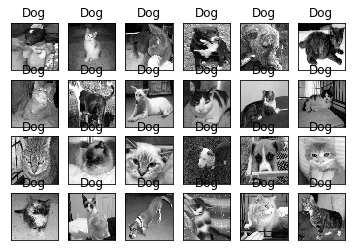

In [44]:
import matplotlib.pyplot as plt
test_data = process_test_data()
fig = plt.figure()
#test_data = np.load('test_data.npy')


for num, data in enumerate(test_data[:24]):
    # cat is 1:0, dog is 0:1
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(4,6, num + 1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label = 'Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()